In [1]:
# import the necessary packages
from sklearn.model_selection import train_test_split
import numpy as np
import pandas as pd
import os, sys
import re
import math
import random
from PIL import Image

import warnings
warnings.filterwarnings('ignore', category=DeprecationWarning)

from subprocess import check_output
print(check_output(["ls", "./data"]).decode("utf-8"))

athenaeum_authors.csv
athenaeum_authors_preview.csv
athenaeum_painting_filtered.csv
athenaeum_painting_movement.csv
athenaeum_painting_movement_test.csv
athenaeum_painting_movement_train.csv
athenaeum_paintings.csv
athenaeum_paintings_sizes.csv
color_hist_kmeans_206552.csv
color_hist_kmeans_distance.csv
color_histograms.csv
color_hist_size_206552.csv
complete_data.csv
extra_tree_com.csv
geolocation_map.csv
grad_boost_com.csv
histogram_color_representatives.csv
images
images_athenaeum
images_sizes_2325.csv
kmeans_centers.csv
kmeans.png
knn_com.csv
model_accuracy.csv
movement_hist_test.csv
movement_hist_train.csv
nbc_com.csv
net1_ensemble_stacking_table.csv
net_predicted.csv
nn_kmeans_test.csv
nn_kmeans_train.csv
painter_info_clean.csv
painting_info_clean.csv
pca20_kmeans_test.csv
pca20_kmeans_train.csv
resized_200
rf_com.csv
test_author200.csv
test_data.csv
test_hist_author_knn.csv
test_hist_author_rf.csv
train_author200.csv
train_data.csv
train_hist_author_knn.csv
train_hist_author_rf.

### Determine painting image file resolution

Here we get the scraped painting list and find which ones correspond to images we have downloaded and, for those, determine the image resolution.

In [2]:
paintings = pd.read_csv('data/athenaeum_paintings.csv')

In [3]:
painting_sizes = []
num_processed = 0
total = len(paintings)
for key, row in paintings.iterrows():
    num_processed += 1
    try:
        image_path = os.path.join('data/images_athenaeum/full',str(row['author_id']) , str(row['painting_id']) + '.jpg')
        if os.path.exists(image_path):
            im = Image.open(image_path)
            painting_sizes.append([im.height, im.width])
        else:
            painting_sizes.append([None, None])
        sys.stdout.write('\r\x1b[2K%d/%d' % (num_processed, total))
        sys.stdout.flush()
    except BaseException as e:
        painting_sizes.append([None, None])
        sys.stderr.write(str(e) + '\n')
        sys.stderr.flush()

print ''
painting_sizes_df = pd.concat((paintings[['author_id', 'painting_id']].reset_index(drop = True),
                               pd.DataFrame(painting_sizes, columns = ['height_px', 'width_px'])), axis = 1)

207353/207353


In [4]:
paintings_reduced = paintings.drop(['height_uom', 'width_uom', 'image_out'], axis = 1)\
    .merge(painting_sizes_df, how = 'inner', on = ['author_id', 'painting_id'])\
    .dropna(subset = ['height_px', 'width_px'])
paintings_reduced['height_px'] = paintings_reduced['height_px'].astype(np.int)
paintings_reduced['width_px'] = paintings_reduced['width_px'].astype(np.int)

In [5]:
paintings_reduced.to_csv('data/athenaeum_paintings_sizes.csv', index = False)

### Filter paintings by type of work

After some data visualization (done elsewhere), we determine some categories that do not correspond to paintings we should be studying, so we apply a filter.

In [8]:
paintings_sized = pd.read_csv('./data/athenaeum_paintings_sizes.csv')
paintings_sized.head(3)

,medium,painting_location,height,article_type,painting_url,painting_dates,painting_title,author_id,painting_id,width,height_px,width_px
0,oil on canvas,Private collection,16.2,Painting,http://www.the-athenaeum.org/art/display_image...,1915,"Zucchini, Tomatoes and Eggplant",24,104839,25.0,842,1280
1,oil on canvas,Private collection,NaN,Painting,http://www.the-athenaeum.org/art/display_image...,1899-1901,"Waterloo Bridge, Hazy Sun",13,3831,NaN,710,1103
2,oil on canvas,Art Institute of Chicago (United States - Chi...,65.0,Painting,http://www.the-athenaeum.org/art/display_image...,1900,"Waterloo Bridge, Grey Weather",13,3268,93.0,571,800


In [9]:
filter_out = ['Collage', 'Stained glass', 'Sculpture']
paintings_filtered = paintings_sized[np.logical_not(paintings_sized['article_type'].isin(filter_out))]
sum(paintings_filtered['article_type'] == 'Collage')

0

In [10]:
paintings_filtered.to_csv('data/athenaeum_painting_filtered.csv', index=False)
paintings_filtered.shape

(206550, 12)

### Find color histogram of paintings

In [3]:
paintings = pd.read_csv('data/athenaeum_painting_filtered.csv')
paintings.head(2)

,medium,painting_location,height,article_type,painting_url,painting_dates,painting_title,author_id,painting_id,width,height_px,width_px
0,oil on canvas,Private collection,16.2,Painting,http://www.the-athenaeum.org/art/display_image...,1915,"Zucchini, Tomatoes and Eggplant",24,104839,25.0,842,1280
1,oil on canvas,Private collection,NaN,Painting,http://www.the-athenaeum.org/art/display_image...,1899-1901,"Waterloo Bridge, Hazy Sun",13,3831,NaN,710,1103


In [12]:
from PIL import Image
from matplotlib import pyplot as plt
%matplotlib inline

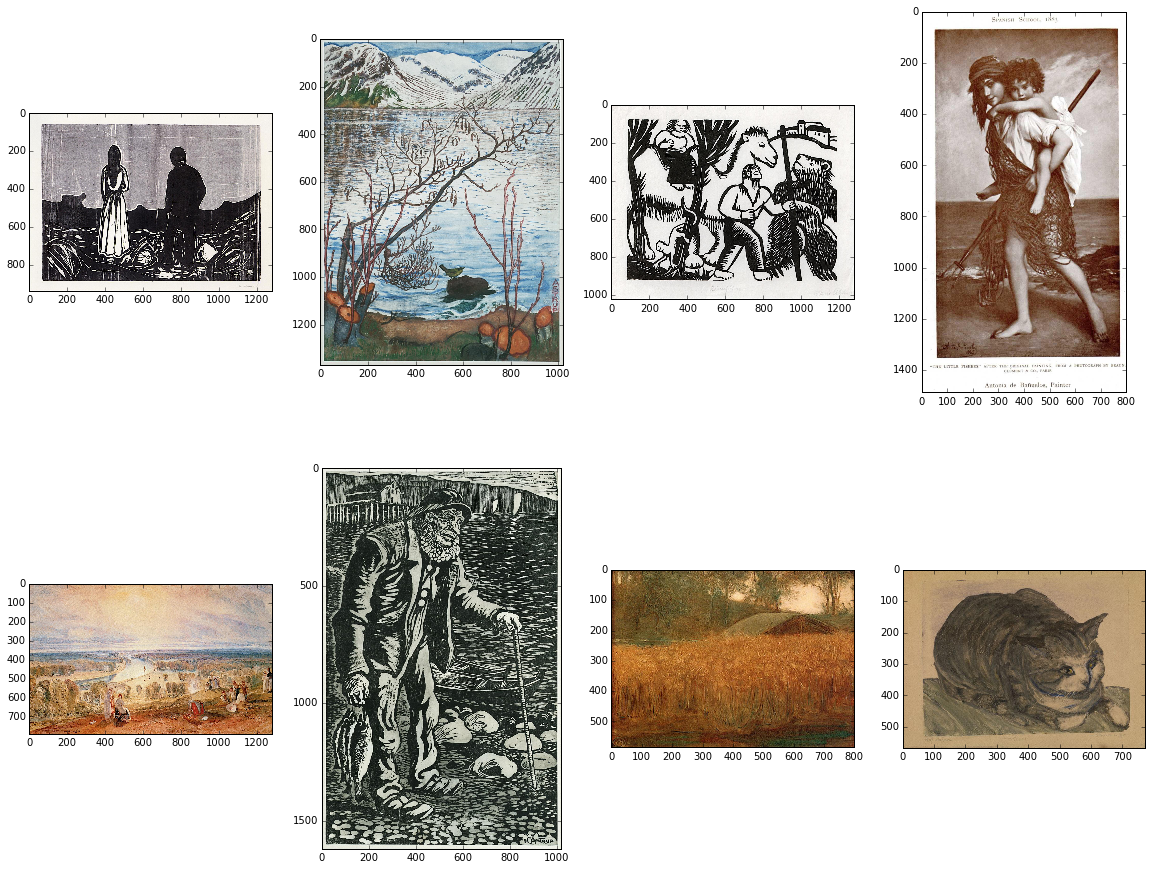

In [52]:
sample_painting = paintings[paintings['article_type'] == 'Print'].sample(8)
f, ax = plt.subplots(2, 4, figsize = (20,15))
for i in range(8):
    im = Image.open('data/images_athenaeum/full/%d/%d.jpg' % (sample_painting.iloc[i]['author_id'],
                                                              sample_painting.iloc[i]['painting_id']))
    ax[i / 4, i % 4].imshow(im)

In [7]:
from concurrent.futures import ThreadPoolExecutor, as_completed, Future
import time
import sys
import cv2

hist_settings = [(0, 20, 0, 180), (1, 5, 0, 256), (2, 5, 0, 256)]
def open_image_rgb(author_id, painting_id):
    return cv2.imread('data/images_athenaeum/full/%d/%d.jpg' % (author_id, painting_id))

def image_histogram(img_rgb):
    img_hsv = cv2.cvtColor(img_rgb, cv2.COLOR_RGB2HSV)
    return np.hstack([cv2.calcHist([img_hsv], [channel], None, [bins], [l, h]).astype(np.float).reshape(bins) 
                      for channel, bins, l, h in hist_settings])

def get_histogram(author_id, painting_id):
    return image_histogram(open_image_rgb(author_id, painting_id)), author_id, painting_id

def get_hist_all(df):
    start_time = time.time()

    histograms = []
    num_completed = 0
    total_guys = df.shape[0]
    with ThreadPoolExecutor(max_workers = 8) as executor:
        executions = [executor.submit(get_histogram, author_id, painting_id)
                      for i, (author_id, painting_id) in df[['author_id', 'painting_id']].iterrows()]
        for future in as_completed(executions):
            histogram, author_id, painting_id = future.result()
            histograms.append((author_id, painting_id, histogram))
            num_completed+=1
            if num_completed % 100 == 0:
                sys.stdout.write('\r%d/%d' % (num_completed, total_guys))
                sys.stdout.flush()
    print '\n%f' % (time.time() - start_time)
    return histograms

In [ ]:
histograms = get_hist_all(paintings_filtered)

In [11]:
histogram_df = pd.DataFrame([[a, p] + list(h.astype(int)) for a, p, h in histograms],
                            columns = ['author_id', 'painting_id'] + ['hist_%02d' % i for i in range(1, 31)])

In [14]:
histogram_df.shape

(206550, 32)

In [16]:
paintings_filtered.shape

(206550, 12)

In [13]:
histogram_df.to_csv('data/color_histograms.csv', index=False)

In [ ]:
import time
start_time = time.time()
color_hist = []
for i, (author_id, painting_id) in paintings_filtered.iloc[['author_id', 'painting_id']].iterrows():
    color_hist.append(get_histogram(author_id, painting_id))
print (time.time() - start_time)

In [57]:
paintings_filtered.shape

(206658, 10)

In [21]:
histogram_df.iloc[:,2:] = histogram_df.iloc[:, 2:].apply(lambda x: x.astype(np.float) / (x.sum()/3), axis = 1, raw = True)

,hist_01,hist_02,hist_03,hist_04,hist_05,hist_06,hist_07,hist_08,hist_09,hist_10,...,hist_21,hist_22,hist_23,hist_24,hist_25,hist_26,hist_27,hist_28,hist_29,hist_30
0,0.017124,3.799550e-03,0.001322,7.837838e-04,9.076577e-04,1.211712e-03,1.511261e-03,2.159910e-03,0.004322,0.015428,...,3.775068e-01,0.188212,0.223286,0.156619,0.054376,0.105572,0.219430,0.264793,0.230477,0.179727
1,0.200286,1.518169e-01,0.005062,1.459546e-03,1.429817e-03,5.501257e-03,8.040952e-04,3.751501e-03,0.007211,0.073681,...,4.232075e-01,0.166300,0.203864,0.140315,0.066314,0.035917,0.089287,0.095728,0.098622,0.680446
2,0.002115,1.055299e-03,0.000888,8.599279e-04,2.015872e-03,4.890193e-03,1.225508e-02,2.390037e-02,0.058308,0.173606,...,3.098923e-01,0.195803,0.258533,0.159779,0.075992,0.114563,0.189451,0.218488,0.254685,0.222813
3,0.074997,3.344668e-02,0.004386,6.149583e-03,5.739371e-03,6.027240e-03,8.869938e-03,1.315917e-02,0.019114,0.022277,...,1.873806e-01,0.541890,0.231057,0.035368,0.004304,0.051194,0.219442,0.301053,0.309807,0.118505
4,0.000748,7.703815e-04,0.001586,5.218150e-03,1.719521e-02,3.762902e-02,3.970830e-02,5.110197e-02,0.077233,0.151690,...,1.713987e-01,0.364460,0.220309,0.150573,0.093259,0.022184,0.096612,0.225069,0.439092,0.217043
5,0.392482,2.371618e-01,0.025837,8.179137e-03,6.549250e-03,8.068906e-02,4.271250e-03,5.911619e-03,0.007185,0.011947,...,5.993498e-01,0.267338,0.114718,0.017272,0.001322,0.066013,0.263579,0.213445,0.171914,0.285049
6,0.006615,6.461650e-03,0.008799,1.033828e-02,1.012663e-02,9.308973e-03,8.133140e-03,1.782562e-02,0.054832,0.190033,...,1.544645e-01,0.377704,0.360289,0.090886,0.016655,0.200953,0.399542,0.335400,0.063486,0.000619
7,0.014432,1.312914e-02,0.004619,3.239351e-03,3.132754e-03,3.097222e-03,2.753744e-03,3.787139e-03,0.005552,0.009141,...,2.505167e-01,0.483818,0.175126,0.064677,0.025862,0.030812,0.080599,0.239102,0.479036,0.170451
8,0.005150,5.413987e-04,0.000143,4.164605e-05,9.578592e-05,2.032327e-04,7.996042e-05,3.964704e-04,0.005706,0.065598,...,2.795066e-01,0.049720,0.117947,0.248283,0.304544,0.057687,0.204824,0.308269,0.157150,0.272069
9,0.018302,3.105371e-02,0.016714,4.745080e-03,1.389761e-02,1.044546e-02,8.150126e-03,2.244818e-02,0.064913,0.244465,...,4.422189e-01,0.057878,0.120260,0.228101,0.151542,0.116326,0.108574,0.094331,0.315185,0.365583


In [24]:
histogram_df.iloc[:, 27:].sum(axis = 1)

0          444000
1          706384
2          675638
3          277905
4          401100
5          572432
6          552800
7          337722
8         1200594
9          382080
10         672048
11        1067520
12         533064
13         562624
14        1277440
15         904774
16         689410
17        1032384
18         486400
19         756012
20        1305600
21        1114880
22         242063
23         647584
24         810000
25         671184
26         524800
27         619264
28         971395
29         592832
           ...   
206520     292800
206521     804864
206522     251395
206523     303455
206524     575840
206525     303455
206526     238800
206527    2595941
206528    2444400
206529    2632434
206530     337705
206531    3579583
206532     334965
206533     301400
206534    2622600
206535    2908000
206536    3132000
206537     256540
206538    3388455
206539    3312000
206540     441922
206541     302325
206542    2475000
206543     302068
206544    

### Find color histogram representatives

We now generate the representative colors for each histogram bin, in order to make nice histogram plots if necessary.

Given that, unadvertedly, all color histograms had the roles of red and blue swapped (due to an unusual convention in openCV), we need to swap them as well when determining the histogram representative colors.

In [1]:
import colorsys
import numpy as np

In [2]:
hues = (np.array([colorsys.hsv_to_rgb((x + 0.5)/20, 1.0, 1.0)[::-1] for x in range(20)]) * 255).astype(np.int)
hues

array([[  0,  38, 255],
       [  0, 114, 255],
       [  0, 191, 255],
       [  0, 255, 242],
       [  0, 255, 165],
       [  0, 255,  89],
       [  0, 255,  12],
       [ 63, 255,   0],
       [140, 255,   0],
       [216, 255,   0],
       [255, 216,   0],
       [255, 140,   0],
       [255,  63,   0],
       [255,   0,  12],
       [255,   0,  89],
       [255,   0, 165],
       [255,   0, 242],
       [191,   0, 255],
       [114,   0, 255],
       [ 38,   0, 255]])

In [3]:
saturations = (np.array([colorsys.hsv_to_rgb(0.0, (x + 0.5)/5, 0.5)[::-1] for x in range(5)]) * 255).astype(np.int)
saturations

array([[114, 114, 127],
       [ 89,  89, 127],
       [ 63,  63, 127],
       [ 38,  38, 127],
       [ 12,  12, 127]])

In [4]:
values = (np.array([colorsys.hsv_to_rgb(0.0, 0.5, (x + 0.5)/5)[::-1] for x in range(5)]) * 255).astype(np.int)
values

array([[ 12,  12,  25],
       [ 38,  38,  76],
       [ 63,  63, 127],
       [ 89,  89, 178],
       [114, 114, 229]])

In [5]:
result = np.apply_along_axis(lambda x: '#%0.2X%0.2X%0.2X' % tuple(x), 1, np.vstack((hues, saturations, values)))
result

array(['#0026FF', '#0072FF', '#00BFFF', '#00FFF2', '#00FFA5', '#00FF59',
       '#00FF0C', '#3FFF00', '#8CFF00', '#D8FF00', '#FFD800', '#FF8C00',
       '#FF3F00', '#FF000C', '#FF0059', '#FF00A5', '#FF00F2', '#BF00FF',
       '#7200FF', '#2600FF', '#72727F', '#59597F', '#3F3F7F', '#26267F',
       '#0C0C7F', '#0C0C19', '#26264C', '#3F3F7F', '#5959B2', '#7272E5'], 
      dtype='|S7')

In [6]:
result.tofile('data/histogram_color_representatives.csv', sep=',', format = '%s')